# Task 1

In [158]:
import numpy as np
from scipy.sparse import coo_matrix
import numba

def discretise(f,g,N):
    #create the A matrix and b vector for the solution
    
    nelements = 5 * (N+2)**2 - 16 * (N+2) + 16
    
    row_ind = np.empty(nelements, dtype=np.float64)
    col_ind = np.empty(nelements, dtype=np.float64)
    data = np.empty(nelements, dtype=np.float64)
    
    b = np.empty((N+2) * (N+2), dtype=np.float64)
    
    count = 0
    for j in range(N+2):
        for i in range(N+2):
            if i == 0 or i == N + 1 or j == 0 or j == N + 1:
                row_ind[count] = col_ind[count] = j * (N+2) + i
                data[count] = 1
                b[j * (N+2) + i] = g[j * (N+2) + i]
                count += 1
                 
            else:
                row_ind[count : count + 5] = j * (N+2) + i
                col_ind[count] = j * (N+2) + i
                col_ind[count + 1] = j * (N+2) + i + 1
                col_ind[count + 2] = j * (N+2) + i - 1
                col_ind[count + 3] = (j + 1) * (N+2) + i
                col_ind[count + 4] = (j - 1) * (N+2) + i
                                
                data[count] = 4 * (N + 1)**2
                data[count + 1 : count + 5] = - (N + 1)**2
                b[j * (N+2) + i] = f[j * (N+2) + i]
                
                count += 5
                                                
    return coo_matrix((data, (row_ind, col_ind)), shape=((N+2)**2, (N+2)**2)).tocsr(), b

In [159]:
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

from scipy.sparse.linalg import spsolve

from math import *
from sympy import *

# comput partitial derivative of u_exact to compute laplace

x, y = symbols('x, y')
u_exact = exp((x-0.5)**2+(y-0.5)**2)
dxdx = diff(diff(u_exact, x), x)
dydy = diff(diff(u_exact, y), y)
laplace = dxdx + dydy


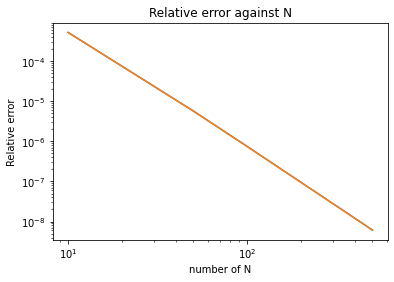

In [162]:
# for u with different dimensions, compute relative error against u_exact

list_N = [10,50,100,300,500]
error = []

for N in list_N:
  # compute exact values and partial differential of u_exact

    F = np.empty((N+2) * (N+2))
    G = np.empty((N+2) * (N+2))
    k = 0
    for i in range(N+2):
        for j in range(N+2):
            lap = -laplace.subs({x: i*(1/(N+1)), y: j*(1/(N+1))})
            exc = u_exact.subs({x: i*(1/(N+1)), y: j*(1/(N+1))})
            F[k] = lap
            G[k] = exc
            k += 1

    A, b = discretise(F,G,N)
    sol = spsolve(A, b)
    u = sol.reshape((N+2,N+2))[1:(N+1),1:(N+1)] # get the solution of u without boundary
    g = G.reshape((N+2,N+2))[1:(N+1),1:(N+1)] # get the u_exact without boundary

    e = []
    for i in range(N):
      # evaluate the relative error between u and u_exact

        e_rel = abs(u.reshape(N*N)[i] - g.reshape(N*N)[i])/abs(g.reshape(N*N)[i])
        e.append(np.float64(e_rel))

    error.append(max(e))

X = list_N
Y = error

# plot the relative error against N

plt.title('Relative error against N')
plt.xlabel('number of N')
plt.ylabel('Relative error')
plt.loglog(X,Y)
plt.show()

### Comment: 

From the loglog plot, we can find that the error of the discretise solution is going to zero as N increases shaped as a straight line. Therefore, it can be induced that the convergence rate is linear.

# Task 2

## GPU computing not using shared memory


In [153]:
import matplotlib.pyplot as plt
from numba import cuda, float32
import numpy as np
import numba
from numba import cuda
import math
from sympy import *

@cuda.jit
def possion_gpu(f,g,u,U,N):
  # compute the solution by GPU

  i, j = cuda.grid(2)
  i_ex = i + 1
  j_ex = j + 1

  if i >= U.shape[0]:
    return
  if j >= U.shape[1]:
    return
    
  # cheat the boundary value with the corresponding g value

  if i == 0 : # for points on the left boundary 
    left = g[i_ex-1, j_ex]
  else:
    left = u[i-1,j]

  if i == U.shape[0] - 1: # for points on the right boundary 
    right = g[i_ex+1,j_ex]
  else:
    right = u[i+1,j]
      
  if j == 0: # for points on the up boundary
    up = g[i_ex,j_ex-1]
  else:
    up = u[i,j-1]

  if j == U.shape[0]-1: # for points on the bottom boundary
    down = g[i_ex, j_ex+1]
  else:
    down = u[i,j+1]

  # for each point, compute the corresponding point of u
  
  U[i,j] = (1/4)*((1/(N+1))**2*f[i,j]+left+right+up+down)
    



In [154]:

def gpu_eval(f,g,N):
  # launch the GPU process and evaluate iteration numbers and errors 

  SX = 32
  SY = 32
  G_error = g[1:(N+1),1:(N+1)] # get u_exact for error evaluation

  # set initialized u_k, u_k1

  u_k = np.zeros((N,N), dtype = np.float32)
  u_k1 = np.zeros((N,N), dtype = np.float32)

  # preload data from host to gpu device 

  f_gpu = cuda.to_device(f)
  g_gpu = cuda.to_device(g)
  u_k_gpu = cuda.to_device(u_k)
  u_k1_gpu = cuda.to_device(u_k1)

  cuda.synchronize()

  # execute an iteration by the GPU function

  nblocks = (N + SX - 1) // SX
  possion_gpu[(nblocks, nblocks), (SX, SY)](f_gpu,g_gpu,u_k_gpu,u_k1_gpu,N)
  u_approx_gpu_0 = u_k1_gpu.copy_to_host()

  # evaluate convergence every 5000 times of iteration to check if it's convergenced

  u_approx_gpu_1 = np.zeros((N,N), dtype = np.float32)

  def converge_eval():
    # execute an iteration round

    count = 0
    while count < 5000:
      u_k_gpu = u_k1_gpu
      possion_gpu[(nblocks, nblocks), (SX, SY)](f_gpu,g_gpu,u_k_gpu,u_k1_gpu,N)
      count += 1

    u_approx_gpu_1 = u_k1_gpu.copy_to_host()
    return u_approx_gpu_1 # return the new value of u after 5000 iterations


  def change(u,U):
    # evaluate the relative change between new u and old u after a round of iteration 

    change = []
    for i in range(U.shape[0]):
      for j in range(U.shape[0]):
        cha = abs(U[i,j] - u[i,j])/abs(u[i,j])
        change.append(cha)
    return max(change)

  change_max = change(u_approx_gpu_0,u_approx_gpu_1)
  change_round = []
  change_round.append(change_max)
  
  def error_exact(U):
    # evaluate the relative error between new u and u_exact after a round of iteration

    error_exact = []
    for i in range(U.shape[0]):
      for j in range(U.shape[1]):
        ee = abs(U[i,j] - G_error[i,j])
        error_exact.append(np.float64(ee))
    return max(error_exact)


  error_exact_iter = [error_exact(u_approx_gpu_1)]
  iter_num = [5000]
  k = 1

  while change_max > np.float32(0):
    # check whether the approximation is convergenced and acquire related elements for plotting

    u_approx_gpu_0 = u_approx_gpu_1
    u_approx_gpu_1 = np.zeros((N,N), dtype = np.float32)
    u_approx_gpu_1 = converge_eval()
    change_max = change(u_approx_gpu_0,u_approx_gpu_1)
    change_round.append(change_max)
    error_exact_iter.append(error_exact(u_approx_gpu_1))
    iter_num.append(k*5000)
    k += 1


  return u_approx_gpu_1, iter_num, change_round, error_exact_iter


In [155]:
# define laplace equation

x, y = symbols('x, y')
u_exact = exp((x-0.5)**2+(y-0.5)**2)
dxdx = diff(diff(u_exact, x), x)
dydy = diff(diff(u_exact, y), y)
laplace = dxdx + dydy


def main(N):
  # define relevant arguments and execute the GPU evaluation function gpu_eval(f,g,N)

  F = np.empty((N,N), dtype = np.float32)
  G = np.empty((N+2,N+2), dtype = np.float32)
  k = 0
  for i in range(N+2):
      for j in range(N+2):
          exc = u_exact.subs({x: i*(1/(N+1)), y: j*(1/(N+1))})
          G[i,j] = exc
          k += 1
  q = 0
  for i in range(N):
      for j in range(N):
          lap = -laplace.subs({x: i*(1/(N+1)), y: j*(1/(N+1))})
          F[i,j] = lap
          q += 1

  f = F
  g = G

  u_approx_gpu_1, iter_num, change_round, error_exact_iter = gpu_eval(f,g,N)

  return iter_num, change_round, error_exact_iter



In [169]:
# compute the solution by GPU setting differenct N

x_con_1, y_iter_1, y_error_1 = main(100)
x_con_2, y_iter_2, y_error_2 = main(200)
x_con_3, y_iter_3, y_error_3 = main(300)
x_con_4, y_iter_4, y_error_4 = main(400)
x_con_5, y_iter_5, y_error_5 = main(500)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in float_scalars


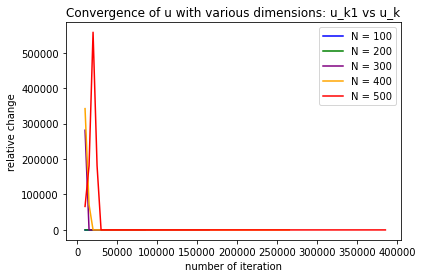

In [148]:
# benchmark convergence of u  with different dimensions by relative change between u_k and u_k+1 
# due to the limit of computer speed, the max of N is set to be 500

plt.plot(x_con_1, y_iter_1, color='blue', label='N = 100')
plt.plot(x_con_2, y_iter_2, color='green', label='N = 200')
plt.plot(x_con_3, y_iter_3, color='purple', label='N = 300')
plt.plot(x_con_4, y_iter_4, color='orange', label='N = 400')
plt.plot(x_con_4, y_iter_4, color='orange', label='N = 500')

plt.title("Convergence of u with various dimensions: u_k1 vs u_k")
plt.xlabel('number of iteration')
plt.ylabel('relative change')
plt.legend()
plt.show()

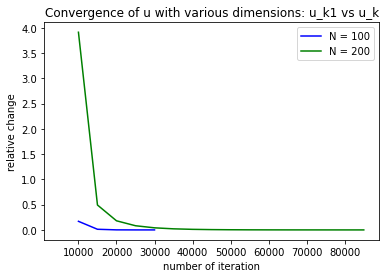

In [170]:
plt.plot(x_con_1, y_iter_1, color='blue', label='N = 100')
plt.plot(x_con_2, y_iter_2, color='green', label='N = 200')

plt.title("Convergence of u with various dimensions: u_k1 vs u_k")
plt.xlabel('number of iteration')
plt.ylabel('relative change')
plt.legend()
plt.show()

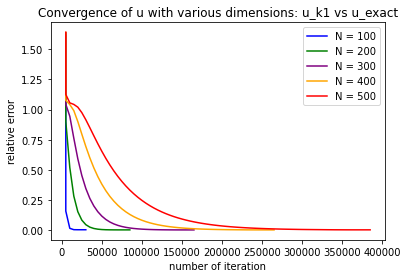

In [149]:
# benchmark convergence of u with different dimensions by relative error between u_k and u_exact 

plt.plot(x_con_1, y_error_1, color='blue', label='N = 100')
plt.plot(x_con_2, y_error_2, color='green', label='N = 200')
plt.plot(x_con_3, y_error_3, color='purple', label='N = 300')
plt.plot(x_con_4, y_error_4, color='orange', label='N = 400')
plt.plot(x_con_5, y_error_5, color='orange', label='N = 500')

plt.title("Convergence of u with various dimensions: u_k1 vs u_exact")
plt.xlabel('number of iteration')
plt.ylabel('relative error')
plt.legend()
plt.show()

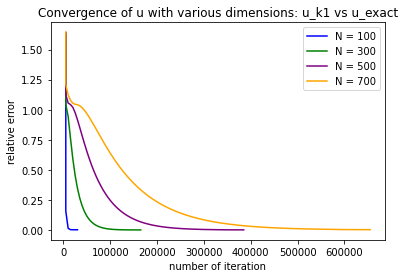

In [168]:
plt.plot(x_con_1, y_error_1, color='blue', label='N = 100')
plt.plot(x_con_2, y_error_2, color='green', label='N = 300')
plt.plot(x_con_3, y_error_3, color='purple', label='N = 500')
plt.plot(x_con_4, y_error_4, color='orange', label='N = 700')

plt.title("Convergence of u with various dimensions: u_k1 vs u_exact")
plt.xlabel('number of iteration')
plt.ylabel('relative error')
plt.legend()
plt.show()

## Comment:

As N grows, the rate of convergence becomes lower. The obvious changes and differences of the rates can be observed when the relative error is around 1.25. Also, more iterations are acquired to achieve 
the same accuracy set before (np.float32) considering a higher N. 

Compared to the discretise solution in Task1 where the convergence seems to be linear, the convergence in Task 2 is not linear with a lower convergence rate.